(sec:expected)=
# Expected Significances and Limits

## Recap

In {numref}`Chapter %s <sec:likelihood>`, we defined our probability model and likelihood function for a simple one bin counting experiment with $n$ events, $s$ expected signal (for a signal strength $\mu$ of 1), and $b$ expected background in our signal region, and $m$ events, $b$ expected background, in our control region:

```{margin}
As discussed in {numref}`Chapter %s <sec:intervals>`, the old parameter of interest (POI) $s$ has been re-parametrized as $\mu\cdot s$, where $\mu$ is now our (POI), called the "signal strength".
```

$$
P(n, m; \mu, b) = \frac{(\mu s+b)^n e^{-(\mu s+b)}}{n!} \cdot \frac{b^m e^{-b}}{m!} = L(\mu, b),
$$ (4model)

and our test statistic $\tilde{t}_\mu$:

$$
\tilde{\lambda}(\mu) = \left\{
    \begin{array}{ll}
      \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, & \mbox{$\hat{\mu}\geq0$}.\\
      \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{\mu}<0$}.
    \end{array}
  \right., \quad \tilde{t}_\mu=-2\ln \tilde{\lambda}(\mu),
$$ (4ts_tilde)

and solved for $\hat{\mu}, \hat{b}, \hat{\hat{b}}(\mu)$ for given $n, m$ to find an analytic form for $t_\mu$.

In {numref}`Chapter %s <sec:hypothesis_testing>`, we translated this to a probability distribution of $\tilde{t}_\mu$ under a particular signal hypothesis $H_\mu$, and quantified the compatibility of our observation based on the $p$-value $p_\mu$ of the observed test statistic $\tilde{t}_\mu^\mathrm{obs}$:

$$
p_\mu = \int_{\tilde{t}_\mathrm{obs}}^{\infty}p(\tilde{t}_\mu|\mu)\mathrm d \tilde{t}_\mu,
$$ (4pvalue)

and it's associated significance.

In {numref}`Chapter %s <sec:intervals>`, we extended this to deriving confidence intervals for parameters of interest by solving for a particular $p$-value:

$$
p = 1 - \mathrm{CL} = \int_{\tilde{t}^\mathrm{obs}_\mu}^{\infty}p(\tilde{t}_\mu|\mu_\pm)\mathrm d \tilde{t}_\mu.
$$ (4cl)

We also defined a new test statistic $\tilde{q}_\mu$ for upper limits:

$$
    \tilde{q}(\mu) = \left\{
      \begin{array}{ll}
        \tilde{t}(\mu), & \mbox{$\hat{\mu} < \mu$}.\\
        0, & \mbox{$\hat{\mu} \geq \mu$}.
      \end{array}
    \right.
    = \left\{
    \begin{array}{ll}
        -2\ln\frac{L(\mu, \hat{\hat{b}}(\mu))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{\mu}<0$}.\\
        -2\ln\frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, & \mbox{0 $\leq \hat{\mu} < \mu$}.\\
        0, & \mbox{$\hat{\mu} \geq \mu$}.
      \end{array}
    \right.
$$ (4qs_tilde)

and introduced the CL$_s$ criterion used in HEP in lieu of the standard $p$-value to avoid excluding signals for which our experiment lacks sensitivity:

$$
p_\mu' = \cfrac{p_\mu}{1 - p_b},
$$ (4pmu_prime)

Code from previous chapters:

In [2]:
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, chi2
import warnings
from IPython.display import display, Latex

plt.rcParams.update({"font.size": 16})
warnings.filterwarnings("ignore")

In [3]:
def log_poisson_nofactorial(n, mu):
    return -mu + n * np.log(mu)


def log_likelihood_nofactorial(s, b, n, m):
    return log_poisson_nofactorial(n, s + b) + log_poisson_nofactorial(m, b)


def shat(n, m):
    return n - m


def bhat(n, m):
    return m


def bhathat(s, n, m):
    """Using the quadratic formula and only the positive solution"""
    return ((n + m - 2 * s) + np.sqrt((n + m - 2 * s) ** 2 + 8 * s * m)) / 4


def t_s(s, n, m, b=None):
    """-2ln(lambda), b can optionally be fixed (for demo below)"""
    bhh, bh = (bhathat(s, n, m), bhat(n, m)) if b is None else (b, b)
    return -2 * (
        log_likelihood_nofactorial(s, bhh, n, m) - log_likelihood_nofactorial(shat(n, m), bh, n, m)
    )


def t_zero_s(s, n, m):
    """Alternative test statistic when shat < 0"""
    return -2 * (
        log_likelihood_nofactorial(s, bhathat(s, n, m), n, m)
        - log_likelihood_nofactorial(0, bhathat(0, n, m), n, m)
    )


def t_tilde_s(s, n, m):
    #     s, n, m = [np.array(x) for x in (s, n, m)]  # convert to numpy arrays
    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    ts = np.array(t_s(s, n, m))
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]
    return ts.squeeze()


def q_tilde_s(s, n, m):
    ts = np.array(t_s(s, n, m))

    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]

    upper_shat_mask = shat(n, m) > s
    ts[upper_shat_mask] = 0

    return ts.squeeze()

In [4]:
def get_toys_sb(s, b, num_toys):
    """Generate toy data for a given s and b"""
    # sample n, m according to our data model (Eq. 1)
    n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
    return n, m


def get_toys(s, n_obs, m_obs, num_toys):
    """Generate toy data for a given s and observed n and m"""
    #  use b^^ for p(t_s|s) as recommended by Ref. 2
    b = bhathat(s, n_obs, m_obs)
    return get_toys_sb(s, b, num_toys)


def get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the t_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return t_tilde_s(test_s, n, m)


def get_ps_val(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    t_tilde_ss = get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s)
    t_obs = t_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(t_tilde_ss > t_obs)
    return p_val, t_tilde_ss, t_obs


def get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the q_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return q_tilde_s(test_s, n, m)


def get_pval_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    q_tilde_ss = get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s)
    q_obs = q_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(q_tilde_ss > q_obs)
    return p_val, q_tilde_ss, q_obs


def get_limits_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
        p_b, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    half_num_s = int(len(s_scan) / 2)
    s_low = s_scan[np.argsort(pv_cl_diff[:half_num_s])[0]]
    s_high = s_scan[half_num_s:][np.argsort(pv_cl_diff[half_num_s:])[0]]

    return s_low, s_high


def get_upper_limit_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys)
        p_b, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    s_upper = s_scan[np.argsort(pv_cl_diff)[0]]

    return s_upper

## Expected Significance

The focus so far has been only on evaluating the *results* of experiments.
However, it is equally important to characterize the expected sensitivity of the experiment *before* running it (or before looking at the data).

Concretely, let's continue with our simple example and say we expect $b = 10$ background events and, for a signal strength $\mu = 1$, $s = 10$ signal events. How do we tell if this experiment is at all useful for discovering this signal, i.e., does it have any sensitivity to the signal?  One way is to calculate the significance with which we expect to exclude the background-only hypothesis if the signal were, in fact, to exist.

Practically, this means we are testing $H_0$ and, hence, need $p(\tilde{t}_0|\mu = 0)$ as before. However, now we also need the distribution of the test statistic $\tilde{t}_0$ under the *background + signal* hypothesis $p(\tilde{t}_0|\mu = 1)$. 
Then, by calculating the significance for each sampled $\tilde{t}_0$ under $H_{\mu = 1}$, we can estimate the distribution of expected significances.

As always, things should hopefully be clearer with code:

In [91]:
num_toys = 30000
# generate toys under signal + background hypothesis
s, b = 10, 10
n, m = get_toys_sb(s, b, num_toys)
# sample t_0 under s + b hypothesis
t_tilde_0s = t_tilde_s(0, n, m)
median_t0s = np.median(np.nan_to_num(t_tilde_0s, np.inf))

# generate toys under background-only hypothesis
n, m = get_toys_sb(0, b, num_toys)
# sample t_0 under b-only hypothesis
t_tilde_00 = t_tilde_s(0, n, m)

# convert sampled t_0s under s + b hypothesis into p-values wrt t_0s under b-only hypothesis
# by calculating the p-value for each t_0 under the s + b hypothesis
p_values = np.mean(t_tilde_00[:, np.newaxis] >= t_tilde_0s, axis=0)
# convert to significances
Zs = np.minimum(norm.ppf(1 - p_values), 5)
median_Z = round(np.median(Zs), 2)

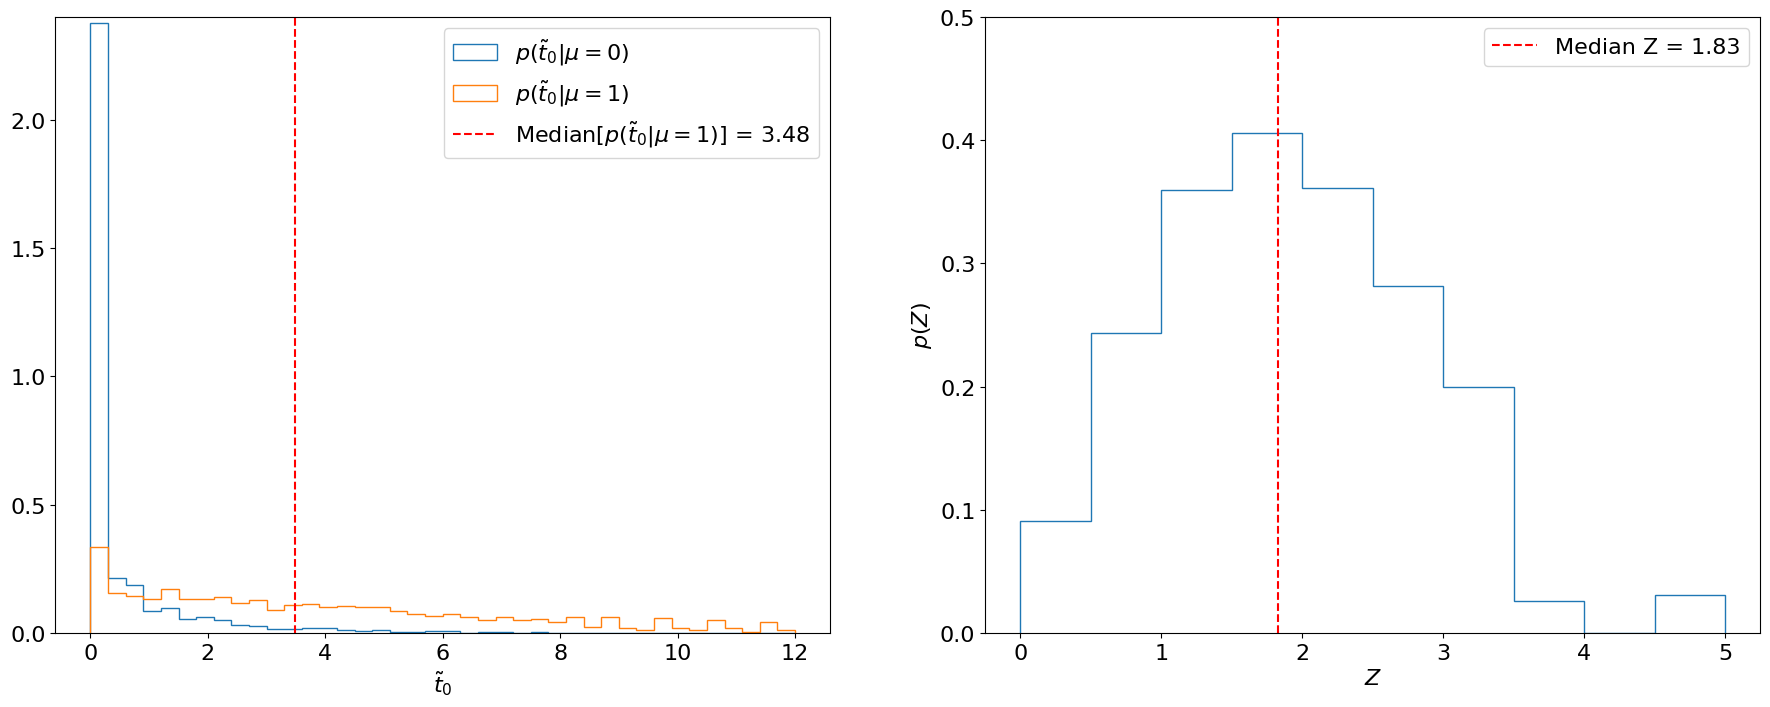

In [92]:
def plot_t0_s0(ax, t_tilde_00, t_tilde0s, median_t0s, hlim=12, ylim=2.4):
    ax.hist(
        t_tilde_00,
        np.linspace(0, hlim, 41),
        histtype="step",
        density=True,
        label=r"$p(\tilde{t}_0|\mu = 0)$",
    )

    ax.hist(
        t_tilde_0s,
        np.linspace(0, hlim, 41),
        histtype="step",
        density=True,
        label=r"$p(\tilde{t}_0|\mu = 1)$",
    )

    ax.vlines(
        median_t0s,
        0,
        ylim,
        linestyle="--",
        label=rf"Median[$p(\tilde{{t}}_0|\mu = 1)$] = {median_t0s:.2f}",
        color="red",
    )

    ax.set_ylim(0, ylim)

    ax.set_xlabel(r"$\tilde{t}_0$")
    ax.legend()


def plot_signs(ax, Zs, median, ylim=0.5):
    ax.hist(Zs, np.linspace(0, 5, 11), histtype="step", density=True)
    ax.set_xlabel("$Z$")
    ax.set_ylabel("$p(Z)$")
    ax.vlines(median_Z, 0, ylim, linestyle="--", label=f"Median Z = {median_Z}", color="red")
    ax.set_ylim(0, ylim)
    ax.legend()


fig, axs = plt.subplots(1, 2, figsize=(22, 8))
plot_t0_s0(axs[0], t_tilde_00, t_tilde_0s, median_t0s)
plot_signs(axs[1], Zs, median_Z)
plt.show()

````{margin}
These quantiles correspond to the cumulative probabilities for a standard Gaussian:

```{figure} figures/gaussian_quantiles.png
---
align: center
name: 4_gaussian_quantiles
---
From Ref. {cite}`Stiller:thesis`.
```
````

```{important}
We usually quote the **median** of this distribution as the expected significance, since the median is "invariant" to monotonic transformations (i.e., the median $p$-value will always correspond to the median $Z$ as well, whereas the mean $p$-value will not correspond to the mean $Z$).
Similarly, we quote the 16%/84% and 2%/98% quantiles as the $\pm 1\sigma$ and $\pm 2\sigma$, respectively, expected significances.
```

In this case, we find the median expected significance to be {eval}`median_Z`.

```{margin}
This is another benefit of considering the median.
```

```{note}
Note that instead of converting each sampled $\tilde{t}$ under $H_{\mu=1}$ into a significance and finding the median of that distribution, as in {numref}`4expZ` (right), we could have directly used the significance of the median $\tilde{t}$ under $H_{\mu=1}$ ({numref}`4expZ`, left). We will do this below for the expected limit.
```

## Expected Limit

```{margin}
95% is the standard confidence level used for upper limits in HEP.
```

The other figure of merit we care about in searches is the upper limit set on the signal strength.
To derive the *expected* limit, we do the opposite of the above and ask, if the signal were not to exist, what value of $\mu$ would we expect to exclude at the 95% confidence level.

```{margin}
Note that $p_b = \int^{\mathrm{median}[p(\tilde{q}_\mu|0)]}_{-\infty}p(\tilde{q}_\mu|0)\mathrm d \tilde{q}_\mu = 0.5$ by definition, so we can plug that in directly into Eq. {eq}`4pmu_prime`. (Same goes for any other quantile.)
```

This means we need:
1. The distribution $p(\tilde{q}_\mu|\mu)$ as in Part 3 to solve for $\mu^+$ in Eq. {eq}`4cl` and be able to do the upper limit calculation;
2. $p(\tilde{q}_\mu|0)$ (or, as we'll see, just its median / quantiles) to get the expected $\tilde{q}_\mu^\mathrm{obs}$ for different signal strengths ($\mu$) under the background-only hypothesis: and, furthermore,
3. To scan over the different signal strengths to find the $\mu$ that results in a median $p$-value of 0.05 (or rather $p_\mu'$ value, from Eq. {eq}`4pmu_prime`, since we're using the CL$_s$ method for upper limits).

First, let's look at the first two steps for just the $\mu = 1$ signal strength, where we expect $s = 10, b = 10$ signal and background events like above.
This is similar to, and essentially an inversion of, the procedure for the expected significance: we're now finding the median expected $p_{\mu=1}'$-value with respect to the signal + background hypothesis, for test statistics $\tilde{q}_\mu$ sampled under the background-only hypothesis.

In [16]:
num_toys = 30000
exp_s, exp_b = 10, 10
# generate toys under signal + background hypothesis
n, m = get_toys_sb(exp_s, exp_b, num_toys)
# sample q under s + b hypothesis
q_tilde_ss = q_tilde_s(exp_s, n, m)

# generate toys under background-only hypothesis
n, m = get_toys_sb(0, exp_b, num_toys)
# sample t_0 under b-only hypothesis
q_tilde_s0 = q_tilde_s(exp_s, n, m)
median_qs0 = np.median(np.nan_to_num(q_tilde_s0, np.inf))

# CL_s
p_mu = np.mean(q_tilde_ss >= median_qs0)
p_b = 0.5  # we're looking at the median of p(q_mu | 0) so, by definition, this is 0.5
p_muprime = round(p_mu / (1 - p_b), 3)

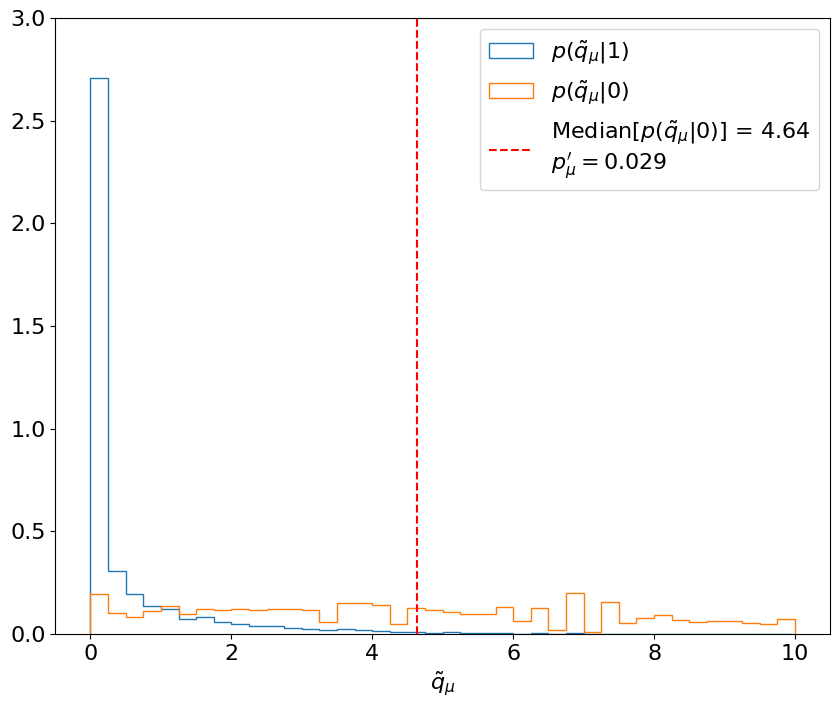

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

hlim = 10
ylim = 3

ax.hist(
    q_tilde_ss,
    np.linspace(0, hlim, 41),
    histtype="step",
    density=True,
    label=r"$p(\tilde{q}_\mu|1)$",
)

ax.hist(
    q_tilde_s0,
    np.linspace(0, hlim, 41),
    histtype="step",
    density=True,
    label=r"$p(\tilde{q}_\mu|0)$",
)

ax.vlines(
    median_qs0,
    0,
    ylim,
    linestyle="--",
    label=rf"Median[$p(\tilde{{q}}_\mu|0)$] = {median_qs0:.2f}" "\n" rf"$p_\mu' = {p_muprime}$",
    color="red",
)

ax.set_ylim(0, ylim)

ax.set_xlabel(r"$\tilde{q}_\mu$")
ax.legend()

plt.show()

The difference with respect to calculating the expected significance is step 3, where this procedure has to be repeated for a range of signal strengths to find the value which gives a median (and $\pm1\sigma,\pm2\sigma$ quantile) $p_\mu'$ of 0.05 - this is thus the minimum value of $\mu$ that we expect to be able to exclude at 95% CL.
This is shown below:

In [54]:
num_toys = 50000
exp_s, exp_b = 10, 10

# saving p_muprime for each mu for each relevant quantile
quantiles = np.array([0.02, 0.16, 0.5, 0.84, 0.98])
p_muprimes = []

mus = np.arange(0.4, 2, 0.01)
for mu in mus:
    s = mu * exp_s
    # generate toys under signal + background hypothesis
    n, m = get_toys_sb(s, exp_b, num_toys)
    # sample q under s + b hypothesis
    q_tilde_ss = q_tilde_s(s, n, m)

    # generate toys under background-only hypothesis
    n, m = get_toys_sb(0, exp_b, num_toys)
    # sample t_0 under b-only hypothesis
    q_tilde_s0 = q_tilde_s(s, n, m)

    qs0_quantiles = np.quantile(np.nan_to_num(q_tilde_s0, np.inf), quantiles)

    # CL_s
    p_mu = np.mean(q_tilde_ss[:, np.newaxis] >= qs0_quantiles, axis=0)
    p_b = quantiles
    p_muprimes.append(p_mu / (1 - p_b))

p_muprimes = np.array(p_muprimes)
# find the mu which gives the closest value to 0.05 for each quantile
limits = mus[np.argmin(np.abs(p_muprimes - 0.05), axis=0)]

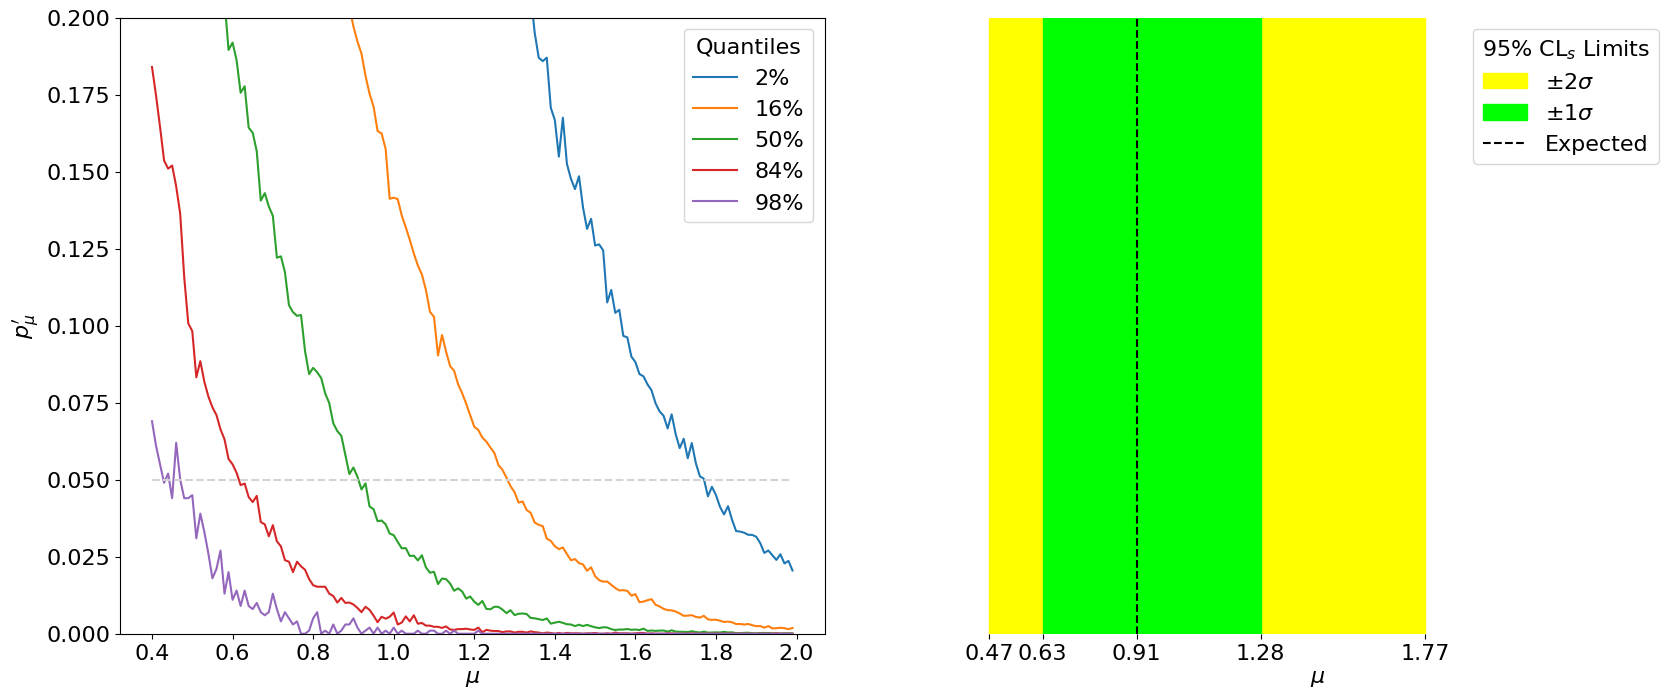

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# plot
ax = axs[0]
ylim = 0.2

for i, q in enumerate(quantiles):
    ax.plot(mus, p_muprimes[:, i], label=f"{q * 100:.0f}%")

ax.hlines(0.05, mus[0], mus[-1], color="lightgrey", linestyle="--")
ax.set_ylim(0, ylim)
ax.legend(title="Quantiles")
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$p_\mu'$")

ax = axs[1]
rl, ru = 0, 1

ax.add_patch(
    matplotlib.patches.Rectangle(
        (limits[0], rl), limits[4] - limits[0], ru - rl, color="yellow", label=r"$\pm 2 \sigma$"
    )
)
ax.add_patch(
    matplotlib.patches.Rectangle(
        (limits[1], rl), limits[3] - limits[1], ru - rl, color="lime", label=r"$\pm 1 \sigma$"
    )
)
ax.vlines(limits[2], rl, ru, color="black", linestyle="--", label="Expected")
ax.legend(title=r"95% CL$_s$ Limits")

ax.set_xlabel(r"$\mu$")
ax.set_xlim(0.4, 2.5)
ax.set_ylim(rl, ru)

ax.set_xticks(limits)
ax.set_yticks([])
ax.set_frame_on(False)

plt.show()

Thus, we have our expected limits. 
The plot on the right is colloquially known as a "Brazil-band plot", and is the standard way of representing limits. 
For example, below is the corresponding plot by ATLAS for the Higgs discovery (scanning over the Higgs mass):

```{figure} figures/atlas_limits.png
---
align: center
name: 4_atlas_higgs
---
Expected and observed 95% CL$_s$ upper limits for the SM Higgs by ATLAS in 2012, for different hypothetical Higgs masses {cite}`ATLAS:2012yve`.

```{margin}
Reference {cite}`Cranmer:2014lly`'s suggestion is to use the profiled values of the nuisance parameters given the full observations, i.e., $\hat{\hat{b}}(\mu, n_\mathrm{obs}, m_\mathrm{obs})$, where $\mu$ depends on the assumed hypothesis; however, personally, I don't find this very general since often in CMS we don't have access to these observations when we're trying to derive the expected significance.
```

```{note}
One subtlety we skipped over is that we may not have expected values for the nuisance parameters, like $b$, beforehand. In practice, there are a lot of methods developed for estimating these using simulations, or observed data in control regions (e.g. from observing only $m$ in our case), etc., which generally depend on the specific analysis being performed.
```

## Summary

We derived the "expected significance" of a particular signal model by calculating the significance with which we expect to exclude the background-only hypothesis, assuming the signal exists.
We then derived CL$_s$ upper limits we expect to set for a signal model, assuming the signal does *not* exist.
In both cases, we generated toys to estimate the probability distributions of our test statistics; however, in [Part II](./05-asymptotic-form-mle.ipynb), we will go over *asymptotic forms* for these test statistics, which can often be simpler to use.